In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

# Custom State

Up until now, we have seen simple reading and writing to state variables, like so:

In [ ]:
def add(a,b):
    return a+b

class Pow():
    def __init__(self,power):
        self.power = power
    def __call__(self,a):
        return a**self.power
    def __str__(self):
        return f'Pow({self.power})'

def is_b_even(obj):
    return obj['b']%2==0


In [ ]:
from ladle.diagrams import (
    Define,
    V,
    E,
)

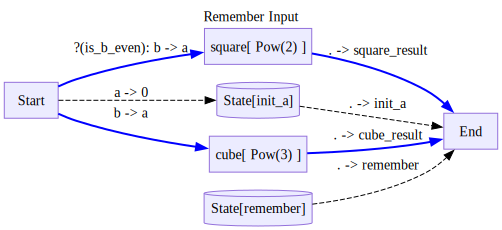

In [ ]:
with Define('Remember Input',type='decision',direction='LR') as D:
    V('square',Pow(2),inputs=[
        ('Start(a=b)',is_b_even),
        ],
        outputs=['End(square_result=.)'])
    V('cube',Pow(3),inputs=['Start(a=b)'],outputs=['End(cube_result=.)'])

    E('Start->State/init_a(0=a)')
    V('End',inputs=['State/init_a(init_a=.)'])
    V('End',inputs=['State/remember(remember=.)'])

In [ ]:
d=D()
for trace in d.run({'a':1,'b':2},state={'remember':100}):
    trace.pprint(skip_passthrough=True)
d.output


Node square:
{'input': {'a': 2}, 'output': 4}


{'square_result': 4, 'init_a': 1, 'remember': 100}

However, sometimes we would like to read and write state in a more customized way,
for example:

* Appending to a list or getting the last item from it
* Fetching the next item from a queue
* reading/writing from/to a database

Naively, this requires as to complicate our diagrams with additional nodes and helper functions that obscure the business logic of our diagram. 

To remedy this, Ladle allows passing custom state objects to be used.

First, let us understand what is going on under the hood:
* Ladle can accept as State any [Pydantic](https://docs.pydantic.dev/latest/) Model.
* By default, we supply every Ladle diagram with `BaseModelExtra` which we will see bellow.
* If we want to be able to serialize the diagram state, we need to make sure our Model is json serializable.

In [ ]:
from ladle.diagrams import BaseModelExtra
import inspect


As you can see, `BaseModelExtra` is a pydantic model that allows setting and getting arbitraty attributes.

In [ ]:
print(inspect.getsource(BaseModelExtra))

class BaseModelExtra(BaseModel):
    model_config = ConfigDict(extra='allow')



When we are calling `run` with the `state` argument, we can supply and object that can be initialized as our state object.

If we are calling run on a diagram that has stopped during a breakpoint, we can supply any object that can be merged with the existing state and then instantiated as our state class.

Let us see several examples of custom states:

## TLDR

In [ ]:
from pydantic import BaseModel, ConfigDict, computed_field
from typing import Annotated

In [ ]:
# a custom state is any basemodel
class CustomState(BaseModel):
    # we can allow arbitrary attributes by setting extra='allow'
    # this is useful for defining on the fly state keys with normal behavior
    model_config = ConfigDict(extra='allow')

    # we can define normal attributes that will be part of the serialized state
    history:list[int] = list()
    
    # we can define private attributes that will not be part of the serialized state
    # to be used internally by other methods
    _hidden_attribute:str = 'hidden'

    # we can define computed fields that will be computed on access
    # these can be read, but not written to
    @computed_field
    def last_message(self)->int:
        if len(self.history) == 0:
            return 0
        return self.history[-1]

    # if we want to use the default getter for an object, but use a custom setter
    # we can annotate the attribute with the setter function
    annoated_list: Annotated[list[int],list.append] = list()

    # we can write custom getter methods that only take self, that will be called when reading from
    # state/first_message
    def first_message(self)->int:
        if len(self.history) == 0:
            return 0
        return self.history[0]

    # we can write custom setter methods that only take self, and the value to set
    # and will be called when writing to state/add_message
    def add_message(self,value):
        self.history.append(value)

    # we can also define pythonic properties via the @property decorator
    @property
    def hidden(self):
        return self._hidden_attribute
    @hidden.setter
    def hidden(self,value):
        self._hidden_attribute = value
    
    
    

## Saving history of a node to a list

In [ ]:
def add_1(a:int)->int:
    return a+1

def is_mod_3(a:int)->bool:
    return a%3==0


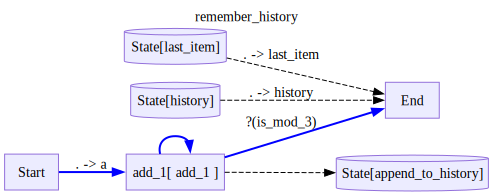

In [ ]:
class CustomState(BaseModel):
    # note that without the extra='allow' we would not be able to set any other state attributes
    history:list[int] = list()

    def append_to_history(self,value:int):
        self.history.append(value)
    
    def last_item(self)->int:
        return self.history[-1]
    
with Define('remember_history',type='decision',direction='LR',state=CustomState) as D:
    V('add_1',add_1,
        inputs=['Start(a=.)'],
        outputs=[
            'State/append_to_history',
            ('End',is_mod_3),
            'add_1'
            ])
    V('End',inputs=[
        'State/last_item(last_item=.)',
        'State/history(history=.)'
        ])


In [ ]:
d = D()
for trace in d.run(0):
    trace.pprint(skip_passthrough=True)
d.output

Node add_1:
{'input': {'a': 0}, 'output': 1}
Node add_1:
{'input': {0: 1}, 'output': 2}
Node add_1:
{'input': {0: 2}, 'output': 3}


{0: 3, 'last_item': 3, 'history': [1, 2, 3]}

## Saving history to list with Annotation

Since appending to a list is so simple, we can use the setter annotation to avoid implementing `append_to_history`

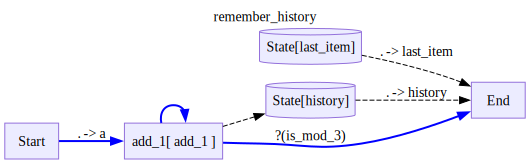

Node add_1:
{'input': {'a': 0}, 'output': 1}
Node add_1:
{'input': {0: 1}, 'output': 2}
Node add_1:
{'input': {0: 2}, 'output': 3}


{0: 3, 'last_item': 3, 'history': [1, 2, 3]}

In [ ]:
class CustomState(BaseModel):
    # note that without the extra='allow' we would not be able to set any other state attributes
    history:Annotated[list[int],list.append] = list()
    
    def last_item(self)->int:
        return self.history[-1]
    
with Define('remember_history',type='decision',direction='LR',state=CustomState) as D:
    V('add_1',add_1,
        inputs=['Start(a=.)'],
        outputs=[
            'State/history',
            ('End',is_mod_3),
            'add_1'
            ])
    V('End',inputs=[
        'State/last_item(last_item=.)',
        'State/history(history=.)'
        ])

d = D()
for trace in d.run(0):
    trace.pprint(skip_passthrough=True)
d.output

## Doing a queue of tasks

In [ ]:
from ladle.std import Condition

In [ ]:
class CustomState(BaseModel):

    queue: list = list()

    def enqueue(self,value):
        self.queue.append(value)

    def pop(self):
        return self.queue.pop(0)

    def len(self):
        return len(self.queue)
    
def do_A_task(task):
    return f'A{task['result']}'

def do_default_task(task):
    return f'Default{task['result']}'

empty = lambda x: x == 0


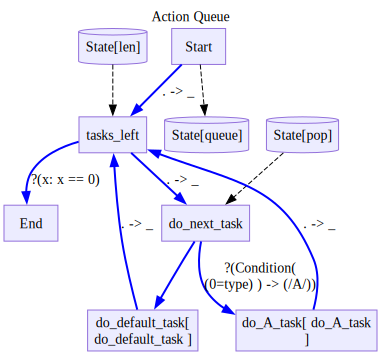

In [ ]:

with Define('Action Queue',type='decision',direction='TB',state=CustomState) as D:
    V('Start',outputs=[
        'State/queue',
        'tasks_left(_)'
        ])
    
    V('tasks_left',
        inputs=['State/len'],
        outputs=[
            ('End',empty),
            'do_next_task(_)'
        ]
        )
    V('do_next_task',
        inputs=['State/pop'],
        outputs=[
            ('do_A_task',Condition('A','(0=type)')),
            'do_default_task',
        ])

    V('do_A_task',do_A_task,outputs=['tasks_left(_)'])
    V('do_default_task',do_default_task,outputs=['tasks_left(_)'])


In [ ]:
d = D()

tasks = [
    {'type':'A','result':1},
    {'type':'B','result':2},
    {'type':'A','result':3},
    {'type':'C','result':4},
]
for trace in d.run(tasks):
    trace.pprint(skip_passthrough=True)
d.output

Node do_A_task:
{'input': {0: {'result': 1, 'type': 'A'}}, 'output': 'A1'}
Node do_default_task:
{'input': {0: {'result': 2, 'type': 'B'}}, 'output': 'Default2'}
Node do_A_task:
{'input': {0: {'result': 3, 'type': 'A'}}, 'output': 'A3'}
Node do_default_task:
{'input': {0: {'result': 4, 'type': 'C'}}, 'output': 'Default4'}


0